In [4]:
# import standard python packages
import glob
import numpy as np
from scipy import optimize, interpolate
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# import our py-pde package: https://github.com/zwicker-group/py-pde
import pde
from pde.tools.math import SmoothData1D

# Read the experimental data

In [6]:
sorted(glob.glob('data/*.txt'))

['data/results_rho0_1200.txt',
 'data/results_rho0_1500.txt',
 'data/results_rho0_2300.txt',
 'data/results_rho0_2700.txt']

In [7]:
density = 1200
name = f'rho0_{density}_1O'
figure = f'figures/{name}'
movie = f'movies/{name}'  # set movie to False if no movies should be created
movie = False

speed_range = (60, 120)

In [8]:
names = ['id', 'r', 'r_l', 'r_r', 'count', 'rho', 'v', 'v_std', 'v_se']
df = pd.read_csv(f'data/results_rho0_{density}.txt', sep='\t', names=names)

In [9]:
df['count_std'] = np.sqrt(df['count'])
df['rho_std'] = df['rho'] * df['count_std'] / df['count']

In [10]:
# create a grid on which the simulation will run
grid = pde.PolarGrid([0, 1500], 64)
rs = grid.axes_coords[0]

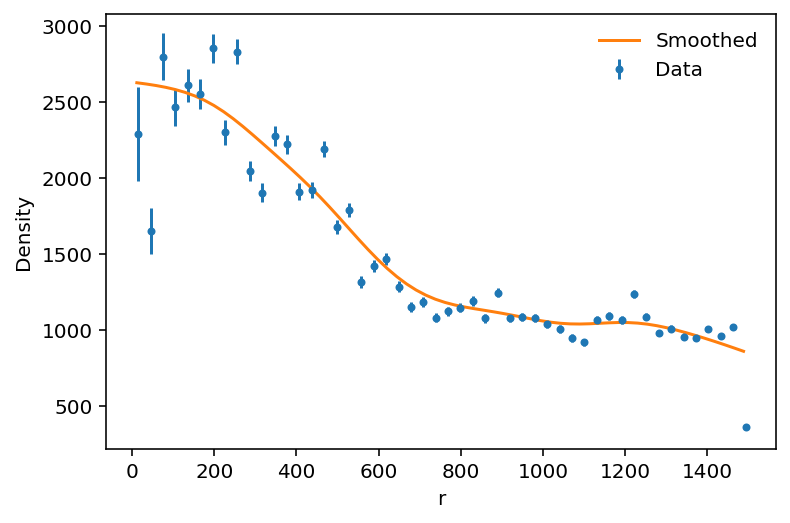

In [11]:
# analyze density plot
df.plot('r', 'rho', yerr='rho_std', linestyle='', marker='.', ylabel='Density', label='Data')
rho = SmoothData1D(df['r'][2:], df['rho'][2:], sigma=100)
plt.plot(rs, rho(rs), label='Smoothed')
plt.legend();

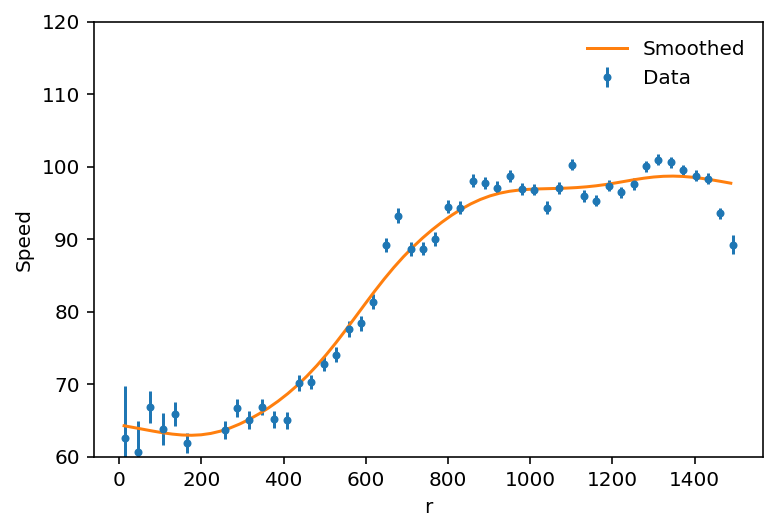

In [12]:
# analyze velocity plot
df.plot('r', 'v', yerr='v_se', linestyle='', marker='.', ylabel='Speed', label='Data')
v = SmoothData1D(df['r'][2:-1], df['v'][2:-1], sigma=100)
plt.plot(rs, v(rs), label='Smoothed')
plt.ylim(*speed_range)
plt.legend();

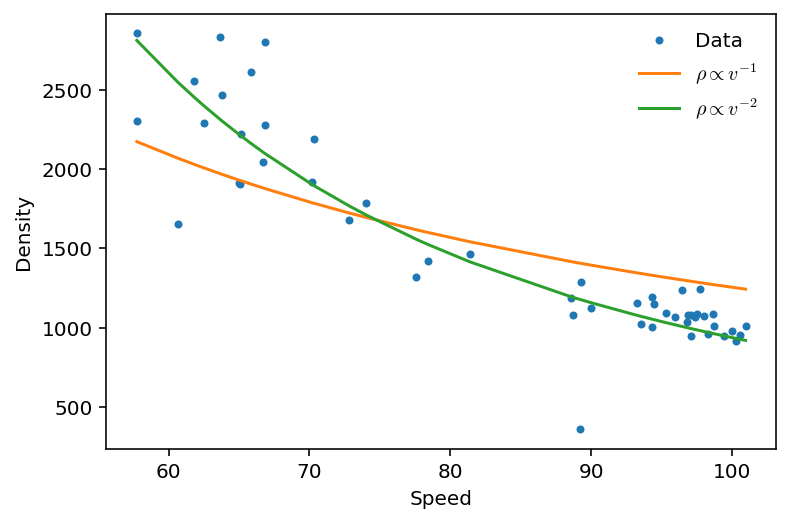

In [14]:
# estimate the relationship between density and velocity
df.plot('v', 'rho', linestyle='', marker='.', label='Data', xlabel='Speed')
vs = np.sort(df['v'])


def dofit(exponent=1):
    def model(x, prefactor):
        return prefactor / x**exponent
    p, _ = optimize.curve_fit(model, df['v'], df['rho'], p0=df['rho'].mean())
    plt.plot(vs, model(vs, p[0]), label=fr'$\rho \propto v^{{-{exponent}}}$')

dofit(1)
dofit(2)

plt.legend(loc='best')
plt.ylabel('Density');

In [15]:
# create scalar fields from the smoothed data
rho_f = pde.ScalarField(grid, rho(rs), label='Density')
v_f = pde.ScalarField(grid, v(rs), label='Speed')

# Determine v(c) using the reaction-diffusion eq (first order)

In [17]:
# parameters from the literature
D = 2000  # μm^2 / s for oxygen in water
h = 21  # μm, height of compartment 
c_sat = 6e-6  # μmol / mm^2  for oxygen in water
c_range = (0, 1.05 * c_sat)

k_single = 1e-5  # μmol  / s; roughly calculated; could be off by orders of magnitude 

eq2 = pde.PDE({'c': f'{D} * laplace(c) - {k_single} * rho * c', 'rho': 0},
              bc=[{'derivative': 0}, {'value': c_sat}])

In [18]:
# simulate the reaction-diffusion system with the measured rho profile (kept fixed)
c0 = pde.ScalarField(grid, c_sat, label='O2 Concentration')
initial = pde.FieldCollection([c0, rho_f])

storage2 = pde.MemoryStorage()
result2 = eq2.solve(initial, t_range=300, dt=0.01, tracker=['progress', storage2.tracker(3)])

  0%|          | 0/300.0 [00:00<?, ?it/s]

In [19]:
if movie:
    pde.movie(storage2, filename=f'{movie}_fixed_rho.mov',
              plot_args={'subplot_args': [{'ax_style': {'ylim': (0, 1.05*c_sat)}}, {}]})

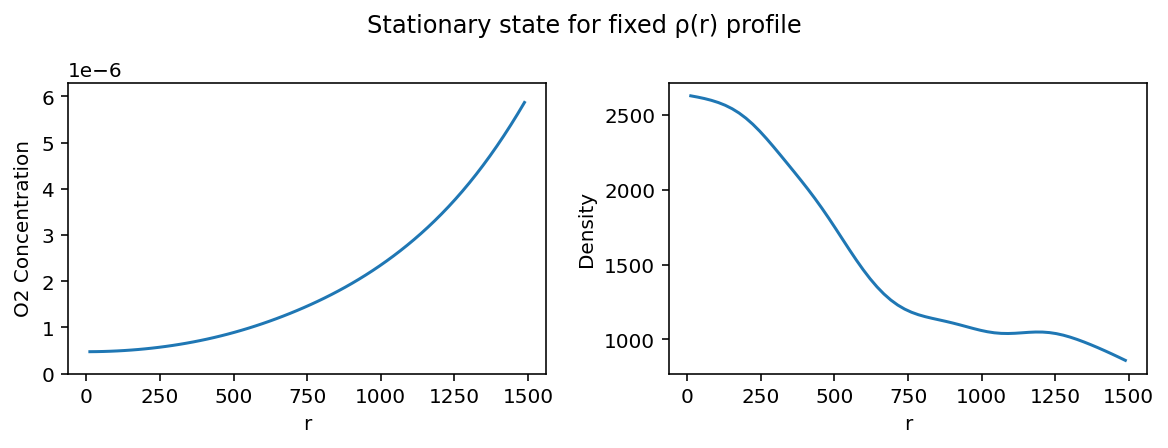

In [20]:
result2.plot(title='Stationary state for fixed ρ(r) profile',
             subplot_args=[{'ax_style': {'ylim': c_range}}, {}]);

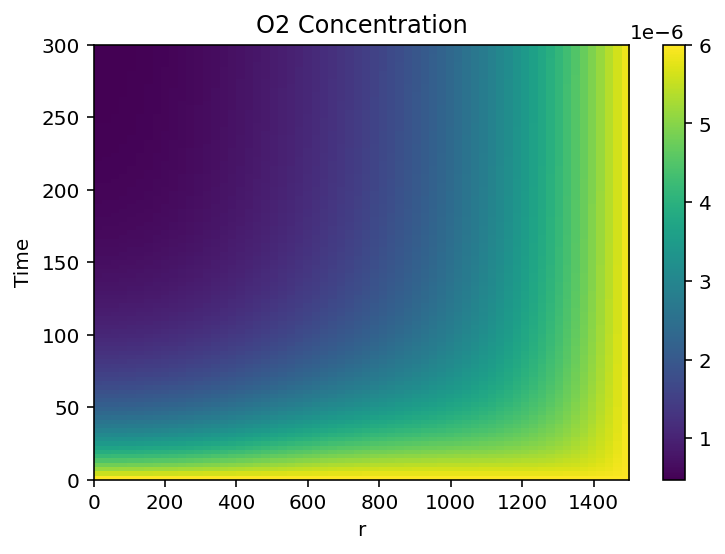

In [21]:
pde.plot_kymograph(storage2, title='O2 Concentration');

In [22]:
# fit the velocity-concentration curve with a sigmoidal model
cs = result2[0].data
def v_c(c, v_min, v_max, c_typ, width):
    return v_min + (v_max - v_min) * (1 + np.tanh((c - c_typ) / width)) / 2
params, _ = optimize.curve_fit(v_c, cs, v_f.data, (70, 100, 3e-6, 1e-6))
params

array([5.65542227e+01, 9.77470300e+01, 9.88158617e-07, 5.78974684e-07])

(60.0, 120.0)

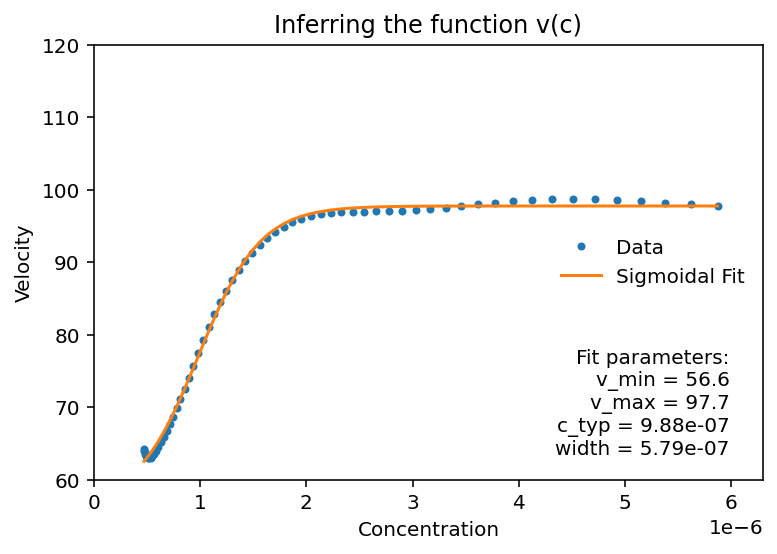

In [23]:
# compare the data v(c) to the model fit
plt.plot(cs, v_f.data, '.', label='Data')
plt.plot(cs, v_c(cs, *params), label='Sigmoidal Fit')
plt.xlabel('Concentration')
plt.ylabel('Velocity');
plt.title('Inferring the function v(c)')
plt.legend(loc='center right')

text = 'Fit parameters:\n'
text += '\n'.join(f'{name} = {val:.3g}'
                  for name, val in zip(['v_min', 'v_max', 'c_typ', 'width'], params))
plt.annotate(text, (0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom')

plt.xlim(*c_range)
plt.ylim(*speed_range)

In [24]:
# predict density kymograph using the fitted v(c) and v ~ rho**-2
def calc_rho(data):
    c, rho_in = data
    v = v_c(c, *params)
    scaling = v**-2
    rho = rho_in.average * scaling / scaling.average
    result = pde.FieldCollection([c, v, rho])
    result.labels = ['Concentration $c$', 'Speed $v$', r'Predicted density $\rho$']
    return result
        
storage_trans = storage2.apply(calc_rho)

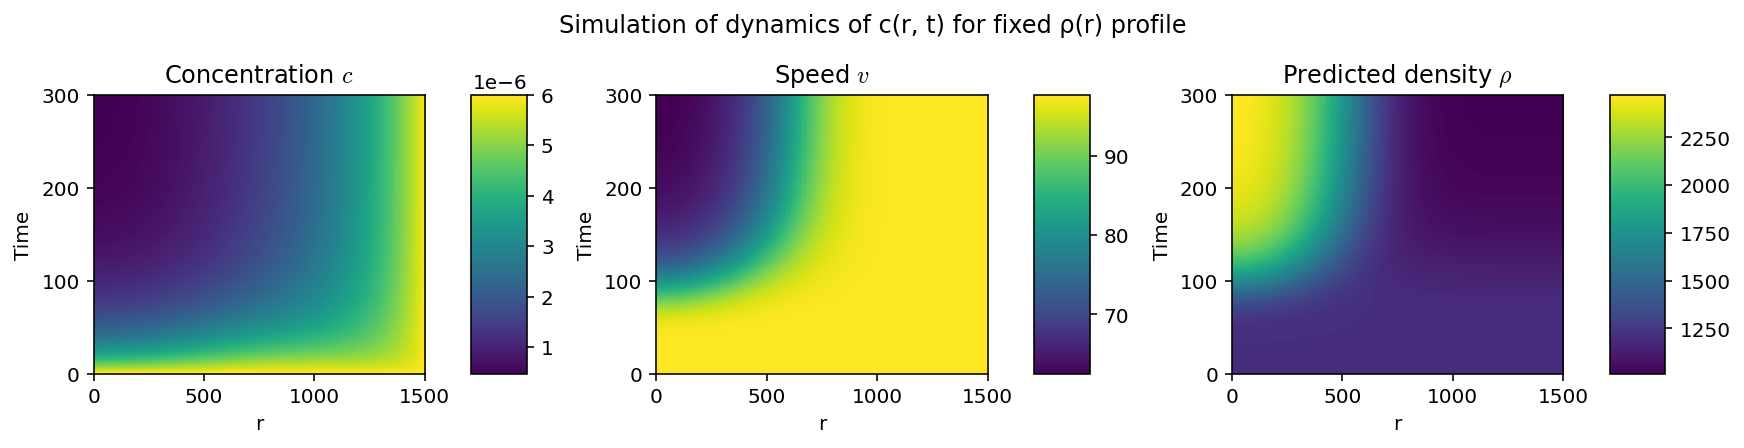

In [25]:
# plot the kymographs 
pde.plot_kymographs(storage_trans, # filename=f'{figure}_kymo_1.pdf',
                    title='Simulation of dynamics of c(r, t) for fixed ρ(r) profile');

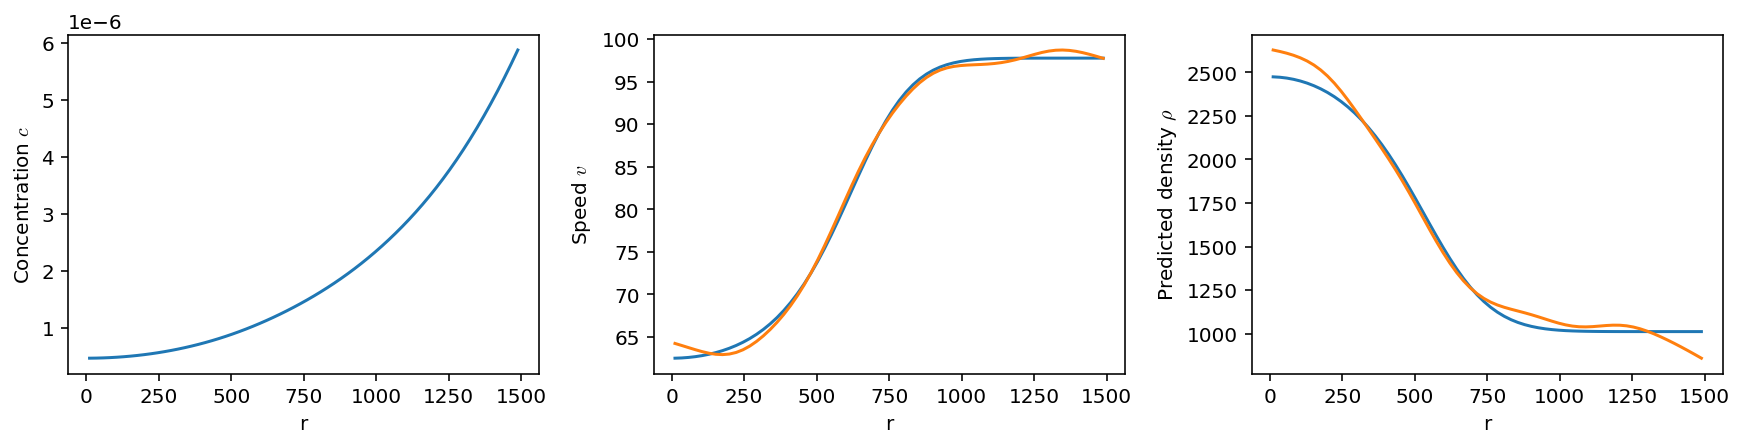

In [26]:
ref = storage_trans[-1].plot(action='create')
ref[1].ax.plot(rs, v(rs))
ref[2].ax.plot(rs, rho(rs))

# Full simulations starting with constant density

In [27]:
class ChlamyPDE(pde.PDEBase):
    """ custom implementation of the PDE """

    D = 2000  # μm^2 / s for oxygen in water
    c_sat = 6e-6  # μmol / mm^2  for oxygen in water
    
    def __init__(self, rho_mean, v_params, k_single=1e-5):
        self.rho_mean = rho_mean
        self.k_single = k_single # μmol  / s
        self.v_min, self.v_max, self.c_typ, self.width = v_params

    def calc_v_c(self, c):
        v = self.v_min + (self.v_max - self.v_min) * (1 + np.tanh((c - self.c_typ) / self.width)) / 2
        v.label = 'Velocity'
        return v
        
    def calc_rho_v(self, v):
        scaling = v**-2
        rho = self.rho_mean * scaling / scaling.average
        rho.label = 'Density'
        return rho
        
    def calc_all(self, c):
        v = self.calc_v_c(c)
        rho = self.calc_rho_v(v)
        result = pde.FieldCollection([c, v, rho])
        result.labels = ['O2 Concentration $c$', 'Speed $v$', r'Density $\rho$']
        return result
        
    def evolution_rate(self, c, t=0):
        rho = self.calc_rho_v(self.calc_v_c(c))
        return self.D * c.laplace([{'derivative': 0}, {'value': self.c_sat}]) - self.k_single * rho * c


In [28]:
eq3 = ChlamyPDE(rho_mean=rho_f.average, v_params=params, k_single=k_single)

In [29]:
# simulate the reaction-diffusion system with the measured rho profile (kept fixed)
c0 = pde.ScalarField(grid, c_sat, label='O2 Concentration')
storage3 = pde.MemoryStorage()
result3 = eq3.solve(c0, t_range=400, dt=0.01, tracker=['progress', storage3.tracker(3)])

  0%|          | 0/400.0 [00:00<?, ?it/s]

In [30]:
st_all = storage3.apply(eq3.calc_all)

In [31]:
if movie:
    ylims = [(0, 1.05 * c_sat), (60, 110), (0, 4000)]
    subplot_args = [{'ax_style': {'ylim': ylim}} for ylim in ylims]
    pde.movie(st_all, filename=f'{movie}_varying_rho.mov',
              plot_args={'subplot_args': subplot_args})

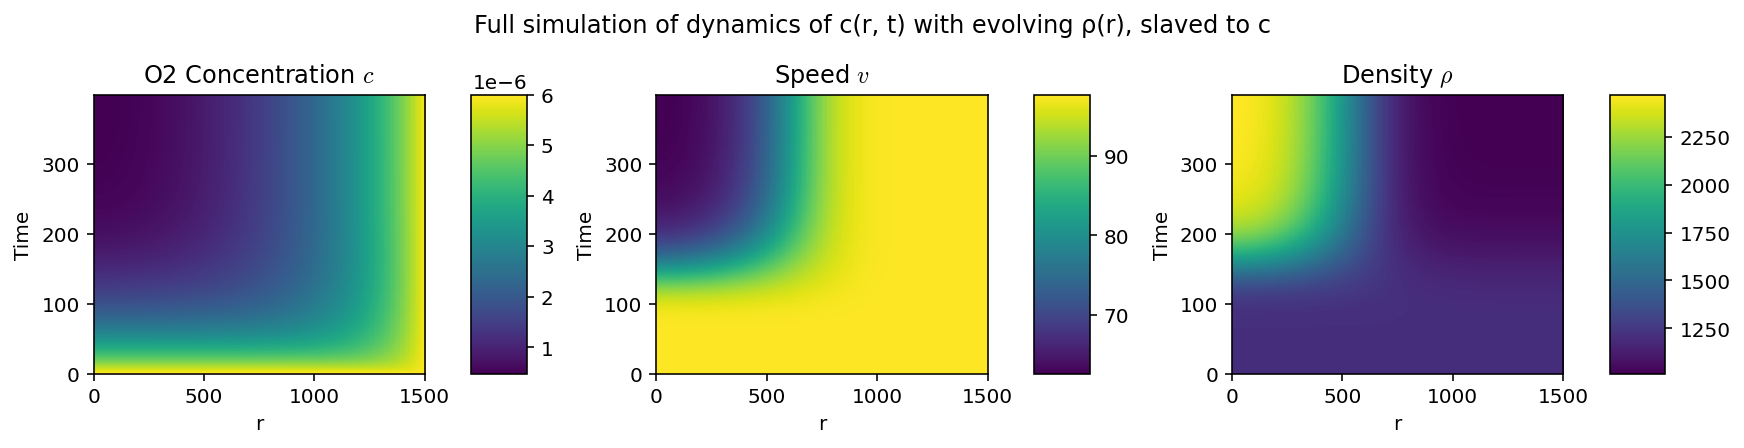

In [32]:
pde.plot_kymographs(st_all, title='Full simulation of dynamics of c(r, t) with evolving ρ(r), slaved to c');

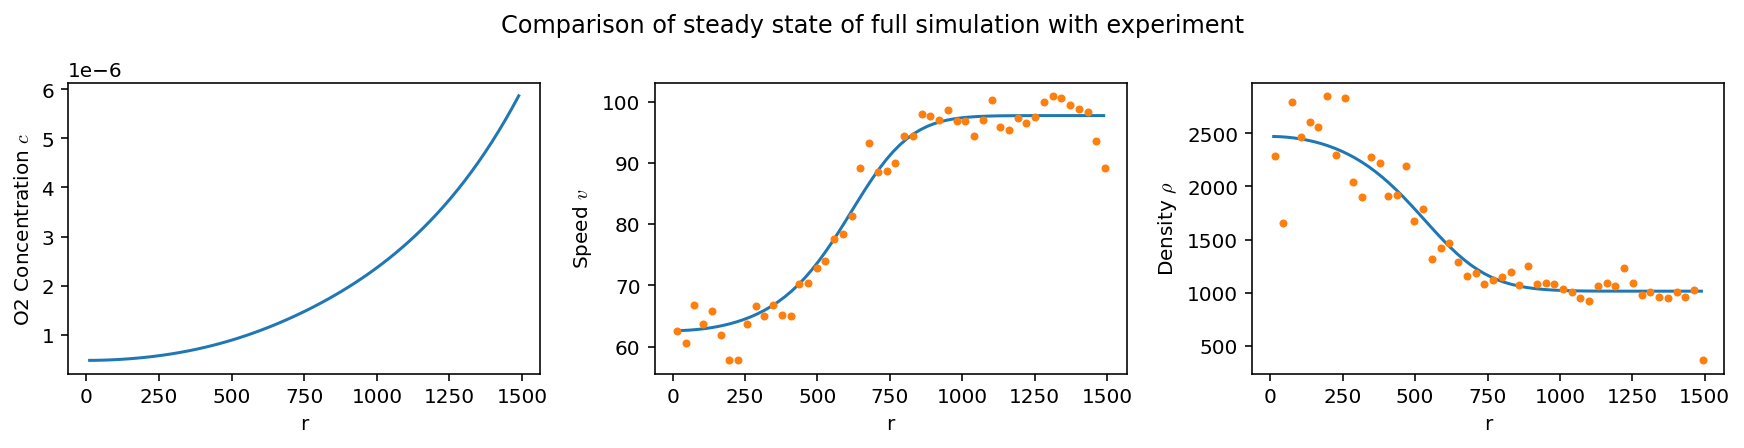

In [33]:
ref = st_all[-1].plot(action='create', title='Comparison of steady state of full simulation with experiment')
ref[1].ax.plot(df['r'], df['v'], '.')
ref[2].ax.plot(df['r'], df['rho'], '.');

In [34]:
fc = st_all[0]
intp = fc[1]._make_interpolator_compiled()
result = []
for fc in st_all:
    result.append([intp(np.array(0), field.data) for field in fc])
data_center = np.array(result)

In [35]:
def pred_v_t(t, v0, t_switch, rate):
    def decay(t):
        return v0 * np.exp(-rate * (t - t_switch))
    return np.piecewise(t, [t < t_switch, t >= t_switch], [v0, decay])

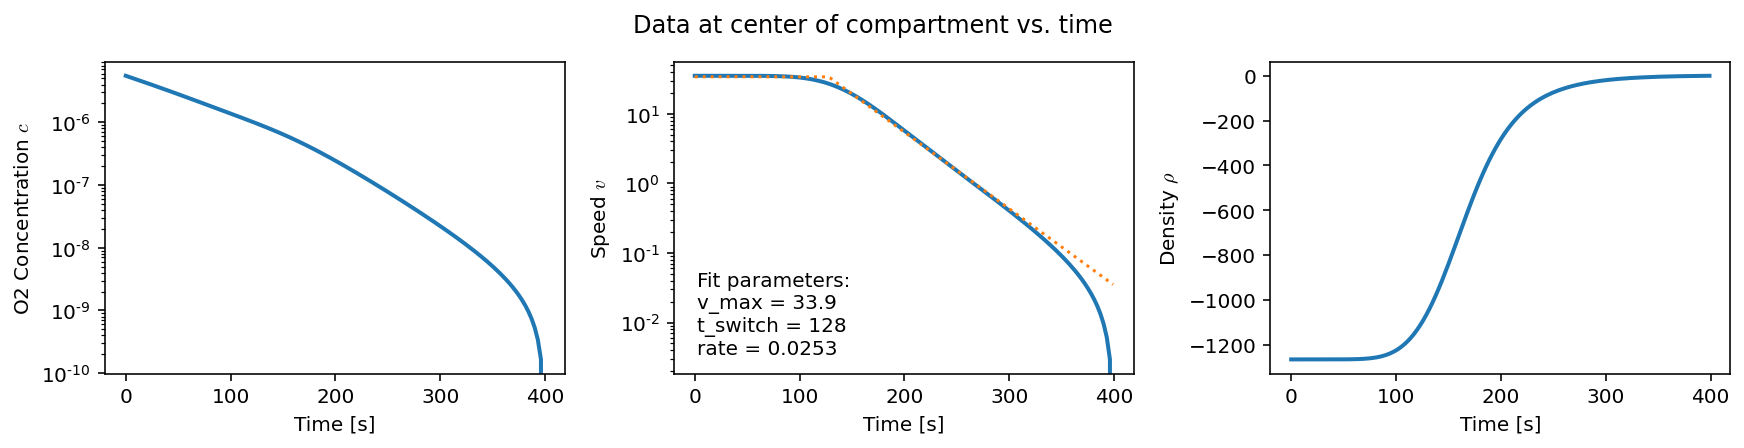

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3), constrained_layout=True)
for i in range(3):
    ax = axs[i]
    xs = np.array(st_all.times)
    ys = data_center[:, i] - data_center[-1, i]
    ax.plot(xs, ys, lw=2)
    if i != 2:
        ax.set_yscale('log')
    if i == 1:
        idx = (np.array(ys) > 0.5)
        f = lambda *args: np.log(pred_v_t(*args))
        params, _ = optimize.curve_fit(f, xs[idx], np.log(ys[idx]), (ys[0], 100, 0.1))
        ax.plot(xs, pred_v_t(xs, *params), ':')
        text = 'Fit parameters:\n'
        text += '\n'.join(f'{name} = {val:.3g}'
                          for name, val in zip(['v_max', 't_switch', 'rate'], params))
        ax.annotate(text, (0.05, 0.05), xycoords='axes fraction', ha='left', va='bottom')
        
    ax.set_ylabel(fc[i].label)
    ax.set_xlabel('Time [s]')
plt.suptitle('Data at center of compartment vs. time');